In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf


#can be reused for other scripts
def load_dataset(input_file,folder = "dataset/"):
    return pd.read_csv(folder+input_file,encoding='utf-8')

In [2]:
#load train+test to make all in one dummies 
print('loading train.csv...')
train = load_dataset('train.csv')
train = train[:]
print('loading test.csv...')
test = load_dataset('test.csv')
print('extracting target variable')
y_train = train['target']
del train['target']

test_id = test['id']
del test['id']

print('merging datasets')
train = pd.concat([train,test]).reset_index()

#make dummies pit pf source_X
print('Making dummies...')
train = train.join(pd.get_dummies(train['source_system_tab'],prefix='source_system'))\
    .join(pd.get_dummies(train['source_type'],prefix='source_type'))\
    .join(pd.get_dummies(train['source_screen_name'],prefix='source_screen'))
#delete the categoricals made into dummies
del train['source_system_tab']
del train['source_screen_name']
del train['source_type']

#getting the size of training set
training_size = y_train.shape[0]
print("size:",training_size)
test = train[training_size:]
test['id'] = test_id
train = train[:training_size]
train['target'] = y_train
train.head()



loading train.csv...
loading test.csv...
extracting target variable
merging datasets
Making dummies...
size: 7377418


C:\Users\Scarou\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,msno,song_id,source_system_discover,source_system_explore,source_system_listen with,source_system_my library,source_system_notification,source_system_radio,source_system_search,...,source_screen_Payment,source_screen_People global,source_screen_People local,source_screen_Radio,source_screen_Search,source_screen_Search Home,source_screen_Search Trends,source_screen_Self profile more,source_screen_Unknown,target
0,0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
#Load members.csv
print('loading members.csv ...')
members = load_dataset('members.csv')

print('getting Events info from training set...')
NumberOfTotalEvents = train.groupby('msno').size()
NumberOfPositive = train[train['target']== 1].groupby('msno').size()

#getting the total events per members
df = NumberOfTotalEvents.to_frame()
df['msno'] = df.index
df.index.name = None
df = pd.DataFrame(df.values)
df = df.rename(columns={0:'nb_events',1:'msno'})

#getting the total Positive events per members
df2 = NumberOfPositive.to_frame()
df2['msno'] = df2.index
df2.index.name = None
df2 = pd.DataFrame(df2.values)
df2 = df2.rename(columns={0:'positive_events',1:'msno'})

#join df and df2
print('joining shit...')
members = members.join(df.set_index('msno'),on='msno').join(df2.set_index('msno'),on='msno')

#getting dummies for gender and NaN genders
print('getting dummies for gender')
members = members.join(pd.get_dummies(members.gender,prefix='gender'))
#delete gender
del members['gender']

#Fill NaNs
print('filling nulls')
members['nb_events'] = members.nb_events.fillna(0)
members['positive_events'] = members['positive_events'].fillna(0)

#getting ratio
print('Calculating positive ratios...')
members['positive_ratio'] = members['positive_events'] / members['nb_events']

#change age to average when odd
mean_age = int(members[(members['bd'] > 10) & (members['bd'] < 80)]['bd'].mean())
mean_age # 28.86 yold
members['bd'] = members['bd'].apply(lambda x: mean_age if (x < 10) or (x > 80) else x)

#Applying minmax to age and nb_events
print('Applying minmaxScaler to age and nb_events')
MMScaler = MinMaxScaler(copy=True, feature_range=(0, 1))
MMScaler.fit(members['bd'].reshape(-1,1))
members['bd'] = MMScaler.transform(members['bd'].reshape(-1,1)).reshape(1,-1)[0]
MMScaler.fit(members['nb_events'].reshape(-1,1))
members['nb_events'] = MMScaler.transform(members['nb_events'].reshape(-1,1)).reshape(1,-1)[0]



#add column: membership_length
members['membership_time'] = members['expiration_date'] -members['registration_init_time']
MMScaler.fit(members['membership_time'].reshape(-1,1))
members['membership_time'] = MMScaler.transform(members['membership_time'].reshape(-1,1)).reshape(1,-1)[0]


members.head(10)

loading members.csv ...
getting Events info from training set...
joining shit...
getting dummies for gender
filling nulls
Calculating positive ratios...
Applying minmaxScaler to age and nb_events


C:\Users\Scarou\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\Scarou\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Scarou\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\Scarou\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\Scarou\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:53: FutureWarning: reshape is deprecated and will raise in a subsequent release

,msno,city,bd,registered_via,registration_init_time,expiration_date,nb_events,positive_events,gender_female,gender_male,positive_ratio,membership_time
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0.264706,7,20110820,20170920,0.114796,560,0,0,0.838323,0.862076
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0.264706,7,20150628,20170622,0.002234,0,0,0,0.000000,0.792997
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0.264706,4,20160411,20170712,0.003953,11,0,0,0.478261,0.776301
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0.264706,9,20150906,20150907,0.001375,0,0,0,0.000000,0.758560
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0.264706,4,20170126,20170613,0.000516,0,0,0,0.000000,0.759397
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,13,0.485294,9,20120703,20171006,0.000516,0,1,0,0.000000,0.845202
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,1,0.264706,4,20160326,20160329,0.000172,0,0,0,0.000000,0.758563
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,0.264706,7,20160130,20170930,0.020107,8,0,0,0.068376,0.777161
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,0.264706,7,20110111,20170930,0.053961,152,0,0,0.484076,0.863315
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,1,0.264706,7,20160217,20170613,0.009795,10,0,0,0.175439,0.776465


In [4]:
#Making the train set, adding to train all the member's stats
del members['city']
del members['registered_via']
del members['expiration_date']
del members['registration_init_time']
del members['positive_events']

In [5]:
#join member values on train
members.head()
joinedTrain =   train.join(members.set_index('msno'),on='msno')
del joinedTrain['target']

In [6]:
joinedTrain.head()

,index,msno,song_id,source_system_discover,source_system_explore,source_system_listen with,source_system_my library,source_system_notification,source_system_radio,source_system_search,...,source_screen_Search Home,source_screen_Search Trends,source_screen_Self profile more,source_screen_Unknown,bd,nb_events,gender_female,gender_male,positive_ratio,membership_time
0,0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,0,1,0,0,0,0,0,...,0,0,0,0,0.264706,0.947070,0,0,0.506442,0.846235
1,1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,0,0,0,1,0,0,0,...,0,0,0,0,0.205882,0.106891,1,0,0.742765,0.862569
2,2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,0,0,0,1,0,0,0,...,0,0,0,0,0.205882,0.106891,1,0,0.742765,0.862569
3,3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,0,0,0,1,0,0,0,...,0,0,0,0,0.205882,0.106891,1,0,0.742765,0.862569
4,4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,0,1,0,0,0,0,0,...,0,0,0,0,0.264706,0.947070,0,0,0.506442,0.846235


In [7]:
X=joinedTrain.as_matrix()
X = X[:,3:]
y = y_train
print(X.shape)
print(y.shape)

(7377418, 48)
(7377418,)


In [10]:
#free memory
del train

In [8]:
#Neural network model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense( 32, input_shape=(48,)))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy','binary_accuracy'])


In [9]:
#Train the network
model.fit(X,y,epochs=30,batch_size=512)

Epoch 1/30
7377418/7377418 [==============================] - 126s - loss: 0.6048 - acc: 0.6645 - binary_accuracy: 0.6645   
Epoch 2/30
7377418/7377418 [==============================] - 123s - loss: 0.6014 - acc: 0.6677 - binary_accuracy: 0.6677   
Epoch 3/30
7377418/7377418 [==============================] - 123s - loss: 0.6014 - acc: 0.6679 - binary_accuracy: 0.6679   
Epoch 4/30
7377418/7377418 [==============================] - 124s - loss: 0.6013 - acc: 0.6680 - binary_accuracy: 0.6680   
Epoch 5/30
7377418/7377418 [==============================] - 156s - loss: 0.6013 - acc: 0.6679 - binary_accuracy: 0.6679   
Epoch 6/30
7377418/7377418 [==============================] - 157s - loss: 0.6013 - acc: 0.6680 - binary_accuracy: 0.6680   
Epoch 7/30
7377418/7377418 [==============================] - 128s - loss: 0.6013 - acc: 0.6680 - binary_accuracy: 0.6680   
Epoch 8/30
7377418/7377418 [==============================] - 109s - loss: 0.6013 - acc: 0.6680 - binary_accuracy: 0.6680   


In [11]:
# serialize model to JSON
model_json = model.to_json()
with open("savedModels/modelMembersDeep.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("savedModels/modelMembersDeep.h5")
print("Saved model to disk")

Saved model to disk


In [2]:
#load model
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [12]:
#making test matrix
joinedTest = test.join(members.set_index('msno'),on='msno')
#fill nan for positive_events
joinedTest['positive_ratio'] = joinedTest['positive_ratio'].fillna(0)
del joinedTest['id']
X_test = joinedTest.as_matrix()[:,3:]
X_test.shape

(2556790, 48)

In [14]:
#no null values yes man
pd.isnull(joinedTest['positive_ratio']).value_counts()

False    2556790
Name: positive_ratio, dtype: int64

In [13]:
y_test = model.predict(X_test)
y_test

array([[ 0.43110636],
       [ 0.43110636],
       [ 0.14926457],
       ..., 
       [ 0.45171613],
       [ 0.45171613],
       [ 0.45171613]], dtype=float32)

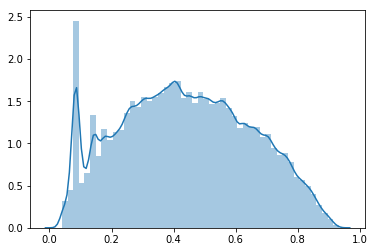

In [14]:
sns.distplot(y_test)

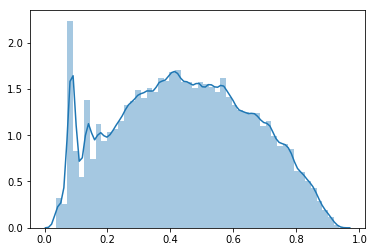

In [16]:
sns.distplot(y_test)

In [15]:
#submission
df = pd.DataFrame(y_test)
df['target'] = df[0]
del df[0]
df['id'] = df.index
df.to_csv('out/neuralMembers5.csv',index=False)